## Preparación

In [2]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor



In [3]:
# Cargar los datos
file_path = "/datasets/taxi.csv"
df = pd.read_csv(file_path)


In [4]:
# Inspeccionar las primeras filas
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [5]:
# Verificar información general del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [6]:
df.duplicated()
#Verificamos la presencia de duplicados

0        False
1        False
2        False
3        False
4        False
         ...  
26491    False
26492    False
26493    False
26494    False
26495    False
Length: 26496, dtype: bool

In [7]:
df.isna().sum()
#Verficamos la presencia de valorres ausentes

datetime      0
num_orders    0
dtype: int64

In [8]:
# Convertir la columna 'datetime' a tipo datetime
df['datetime'] = pd.to_datetime(df['datetime'])
# Establecer la columna datetime como índice
df.set_index('datetime', inplace=True)


In [9]:
df_resampled = df.resample('H').sum()  # Remuestreo a intervalos de 1 hora

- Verificamos que no hay presencia de valores ausentes ni duplicados.

## Análisis

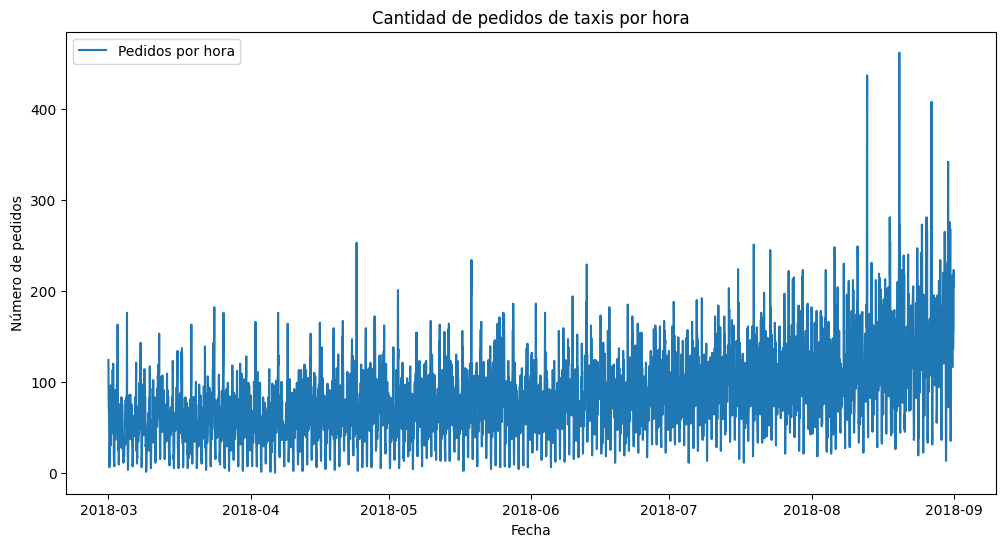

In [10]:
# Visualización inicial
plt.figure(figsize=(12, 6))
plt.plot(df_resampled, label='Pedidos por hora')
plt.title('Cantidad de pedidos de taxis por hora')
plt.xlabel('Fecha')
plt.ylabel('Número de pedidos')
plt.legend()
plt.show()

- El gráfico muestra la cantidad de pedidos de taxis por hora a lo largo del tiempo. 

- Se observa un aumento en la cantidad de pedidos con el tiempo, lo que podría indicar un crecimiento en la demanda de taxis.

- Existen momentos con valores atípicos que sobresalen del resto de los datos.

## Formación

In [11]:
#Crear características basadas en series temporales
df_resampled['hour'] = df_resampled.index.hour
df_resampled['day_of_week'] = df_resampled.index.dayofweek
for lag in range(1, 4):  # Agregar retrasos de 1, 2 y 3 horas
   df_resampled[f'lag_{lag}'] = df_resampled['num_orders'].shift(lag)

# Eliminar filas con valores NaN 
df_resampled.dropna(inplace=True)

In [12]:
# División en conjunto de entrenamiento y prueba
#Separar características y objetivo
target = df_resampled['num_orders']
features = df_resampled.drop('num_orders', axis=1, errors='ignore')

# División de los datos en entrenamiento y prueba
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)


In [13]:
# Árboles de Decisión
dt_model = DecisionTreeRegressor()
dt_model.fit(features_train, target_train)
dt_pred = dt_model.predict(features_valid)


In [14]:
# XGBoost
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb_model.fit(features_train, target_train)
xgb_pred = xgb_model.predict(features_valid)

## Prueba

In [15]:
# 7. Evaluación de modelos
dt_rmse = mean_squared_error(target_valid, dt_pred, squared=False)
xgb_rmse = mean_squared_error(target_valid, xgb_pred, squared=False)

print(f'Árboles de Decisión RMSE: {dt_rmse:.2f}')
print(f'XGBoost RMSE: {xgb_rmse:.2f}')

Árboles de Decisión RMSE: 36.04
XGBoost RMSE: 26.07


In [16]:
dt_pred

array([ 60.,  72.,  65., ..., 123.,  67., 119.])

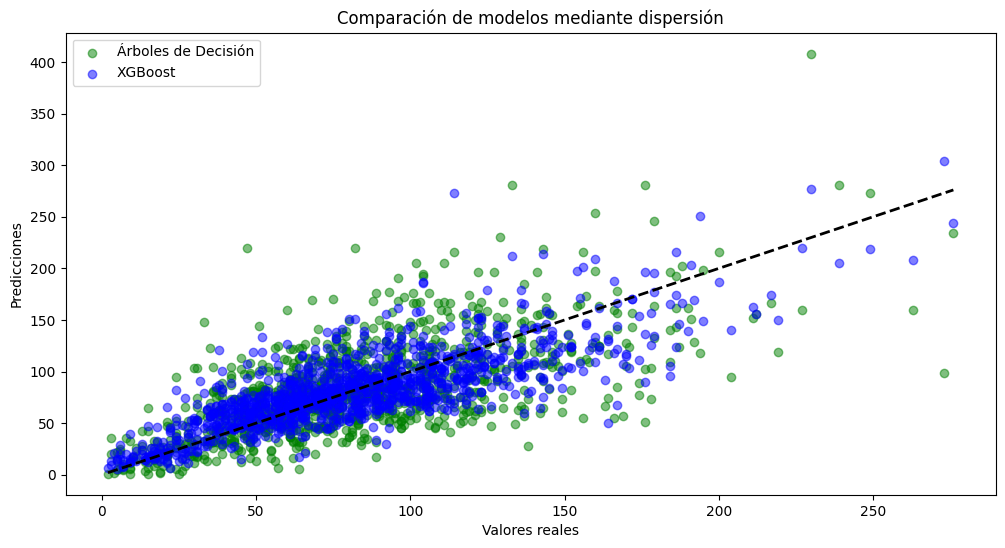

In [18]:

#Visualización de predicciones

plt.figure(figsize=(12, 6))
plt.scatter(target_valid, dt_pred, label='Árboles de Decisión', color='green', alpha=0.5)
plt.scatter(target_valid, xgb_pred, label='XGBoost', color='blue', alpha=0.5)
plt.plot([target_valid.min(), target_valid.max()], [target_valid.min(), target_valid.max()], 'k--', lw=2)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.legend()
plt.title('Comparación de modelos mediante dispersión')
plt.show()


Dado que la métrica RMSE mide la diferencia entre las predicciones y los valores reales, un valor menor indica mayor precisión. Esto sugiere que XGBoost es más eficaz para capturar patrones complejos en los datos y hacer predicciones más precisas, lo cual es crucial para optimizar la toma de decisiones y mejorar la eficiencia en la predicción de la demanda de taxis.